**Work in progress - Will be polishing the notebook and adding new visualization in the future.**

This Jupyter Notebook aims to find out the trend of Python in 2018 using the StackOverflow BigQuery dataset. It is inspired from https://www.kaggle.com/zvone1/state-of-javascript-in-2018-on-stackoverflow. 

These are some of the questions that this notebook aims to answer for now:

1. What is the trend in the number of questions asked which are related to Python from 2008 - 2018?
2. What is the average number of tags used for Python questions?
3. Which country does users asks the most questions?
4. What are the most popular tags?
5. What are the most popular tags in countries where users ask the most questions?

In [29]:
import bq_helper
import matplotlib.pyplot as plt
import pandas as pd



In [30]:
stack_overflow_helper = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="stackoverflow")

Using Kaggle's public dataset BigQuery integration.


In [31]:
python_trends_by_year_query = '''
    select 
        extract(year from questions.creation_date) as year,
        count(distinct questions.id) as python_questions_count,
        count(*) as python_answers_count
        FROM `bigquery-public-data.stackoverflow.posts_questions` questions
        left join `bigquery-public-data.stackoverflow.posts_answers` answers
        on questions.id = answers.parent_id
        where questions.tags like "%python%"
        group by year
        order by year desc
        
'''
stack_overflow_helper.estimate_query_size(python_trends_by_year_query)


0.8684368701651692

In [32]:
python_trends_year = stack_overflow_helper.query_to_pandas_safe(python_trends_by_year_query)
python_trends_year.head()


,year,python_questions_count,python_answers_count
0,2018,244942,329954
1,2017,216867,310139
2,2016,174309,259916
3,2015,147960,230037
4,2014,124171,199051


In [33]:
python_trends_year['question_to_answer_ratio'] = python_trends_year.apply(lambda row: row.python_questions_count / row.python_answers_count, axis=1)
python_trends_year.head()

,year,python_questions_count,python_answers_count,question_to_answer_ratio
0,2018,244942,329954,0.742352
1,2017,216867,310139,0.699257
2,2016,174309,259916,0.670636
3,2015,147960,230037,0.643201
4,2014,124171,199051,0.623815


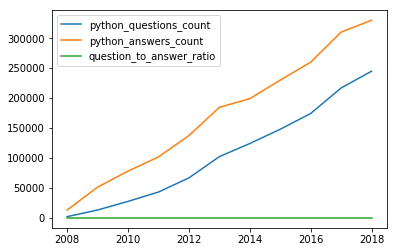

In [34]:
plt.plot('year', 'python_questions_count', data=python_trends_year)
plt.plot('year', 'python_answers_count', data=python_trends_year)
plt.plot('year', 'question_to_answer_ratio', data=python_trends_year)
plt.legend()

In [35]:
# The next thing we want to get is the most popular tags in 2018
python_tags_2018_query = '''
    select 
        questions.tags, questions.view_count, users.location
        from `bigquery-public-data.stackoverflow.posts_questions` questions
        inner join `bigquery-public-data.stackoverflow.users` users
        on users.id = questions.owner_user_id 
        where questions.tags like "%python%"
        and extract(year from questions.creation_date) = 2018
        order by questions.view_count desc
'''
python_tags_2018 = stack_overflow_helper.query_to_pandas_safe(python_tags_2018_query)
def split_location(row):
    if row.location == 'None' or row.location == '':
        return ""
    location = row.location.split(', ')
    if len(location) == 1:
        return location[0]
    return location[-1]

# Also, we need to transform location to country
python_tags_2018['country'] = python_tags_2018.apply(split_location, axis=1)
python_tags_2018 = python_tags_2018.drop(['location'], axis=1)
# Now, we need to count the number of tags per row
python_tags_2018['tag_count'] = python_tags_2018.apply(lambda row: len(row.tags.split('|')), axis=1)
python_tags_2018.head(10)


,tags,view_count,country,tag_count
0,python|pip,135981,India,2
1,python|python-2.7|pip|ssl-certificate,81939,India,4
2,python|pip,59051,,2
3,python|python-3.x|python-2.7|tensorflow|pip,54168,Belgium,5
4,python|pip|pypi,47773,,3
5,install|conda|channel|python-control,41154,,4
6,python|matplotlib|pip|jupyter,40803,,4
7,python|numpy|tensorflow,39339,India,3
8,python-2.7|google-chrome|selenium|selenium-web...,37704,,5
9,python|anaconda|plotly|msgpack,34412,,4


It seems that the 10 questions with the highest view count is mostly related to package management tools such as pip. 3 of the top 10 questions comes from users in India.

Text(0.5,1,'Question view counts by the number of tags')

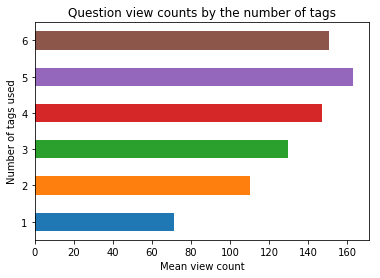

In [36]:
python_tag_group = python_tags_2018.groupby('tag_count')['view_count'].mean()

ax = python_tag_group.plot.barh(x='tag_count', y='view_count')
ax.set_xlabel("Mean view count")
ax.set_ylabel("Number of tags used")
ax.set_title("Question view counts by the number of tags")


It seems that the higher the tag count, the higher the average number of view counts. However, there is a decrease in the average view count 

Let's find out the countries in which users asked the most questions on Stackoverflow.

In [37]:
python_tag_group = python_tags_2018.groupby('country').size().reset_index(name='count')
python_tag_group.sort_values(by='count', ascending=False).head(11)


,country,count
0,,138866
834,India,15991
1949,USA,10274
1973,United States,9343
678,Germany,3682
347,Canada,3197
1969,United Kingdom,2981
1943,UK,2845
629,France,2535
155,Australia,1730


It looks like the majority of questions were asked by developers based in India. USA, Germany, Canada and the UK also topped the list. Surprisingly, Israel was number 10 on this list. 

In [38]:
# Time to find the most popular tags for python
# What we need to do now is to create a new dataframe
col_names = ['tag', 'country']
tag_list = []
for row in python_tags_2018.itertuples():
    for tag in row[1].split('|'):
        if tag != "python":
            tag_list.append({'tag': tag, 'country': row[3]})

tag_df = pd.DataFrame(tag_list, columns=col_names)
tag_df.head(5)

,tag,country
0,pip,India
1,python-2.7,India
2,pip,India
3,ssl-certificate,India
4,pip,


In [39]:
# Group by tags to view how in how many questions were the tags used.
tag_count_df = tag_df.groupby('tag').size().reset_index(name='count')
tag_count_df.sort_values(by=['count'], ascending=False).head(10)


,tag,count
9101,python-3.x,52385
8075,pandas,28753
2839,django,15945
9090,python-2.7,11385
7594,numpy,10804
11535,tensorflow,10430
2480,dataframe,8753
6658,matplotlib,6919
6325,list,6358
3967,flask,5061


**Insights:**

1. Django was tagged 3.15 times more often compared to Flask.
2. Libraries commonly used in data science such as pandas, numpy, tensorflow and matplotlib were amongst the top 20 tags. 

**For developers based in India, USA and Germany, what were their most asked questions? **

Text(0.5,1,'Most used tags by developers in India when asking questions')

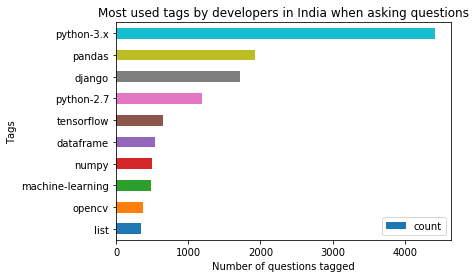

In [43]:
india_tag_df = tag_df[tag_df['country'] == "India"]
india_tag_df = india_tag_df.groupby('tag').size().reset_index(name='count')
india_tag_df = india_tag_df.sort_values(by=['count'], ascending=False)
ax = india_tag_df.head(10)[::-1].plot.barh(x='tag', y='count')
ax.set_xlabel("Number of questions tagged")
ax.set_ylabel("Tags")
ax.set_title("Most used tags by developers in India when asking questions")


It seems that the tags that were used by developers in India were mostly similar to the tags used by developers worldwide.

Text(0.5,1,'Most used tags by developers in the USA when asking questions')

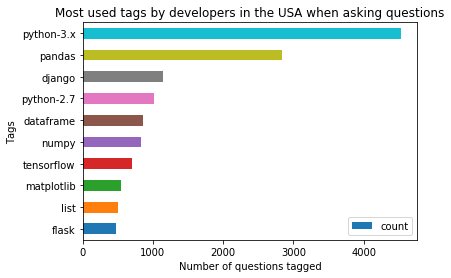

In [44]:
usa_tag_df = tag_df[(tag_df['country'] == "USA") | (tag_df['country'] == "United States")].groupby('tag').size().reset_index(name='count')
usa_tag_df = usa_tag_df.sort_values(by=['count'], ascending=False)
ax = usa_tag_df.head(10)[::-1].plot.barh(x='tag', y='count')
ax.set_xlabel("Number of questions tagged")
ax.set_ylabel("Tags")
ax.set_title("Most used tags by developers in the USA when asking questions")

Tags used by developers in the USA when asking questions looks mostly identical to their counterpart in India.

Text(0.5,1,'Most used tags by developers in Germany when asking questions')

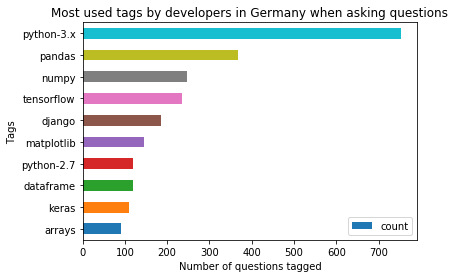

In [45]:
germany_tag_df = tag_df[(tag_df['country'] == "Germany")].groupby('tag').size().reset_index(name='count')
germany_tag_df = germany_tag_df.sort_values(by=['count'], ascending=False)
ax = germany_tag_df.head(10)[::-1].plot.barh(x='tag', y='count')
ax.set_xlabel("Number of questions tagged")
ax.set_ylabel("Tags")
ax.set_title("Most used tags by developers in Germany when asking questions")

For developers in Germany, it is also mostly similar to their counterpart based in the USA or India. 

An interesting observation is that Keras has made it to the top 10.